In [37]:
%load_ext notexbook
%texify -v

The notexbook extension is already loaded. To reload it, use:
  %reload_ext notexbook


# Sensetivity Analysis of Magnetic Diffusion Equation

The Galactic Dynamo Diffusion Equation describes the evolution of the magnetic field components $ \bar{B}_r $ and $ \bar{B}_\phi $ in the galaxy over time. It is given by two coupled partial differential equations:

1. **Radial Magnetic Field Equation:**
   $$
   \frac{\partial \bar{B}_r}{\partial t} = \eta_t\frac{\partial^2 \bar{B}_r}{\partial z^2}
   $$
   This equation describes how the radial component of the magnetic field changes with time due to diffusion.

2. **Azimuthal Magnetic Field Equation:**
   $$
   \frac{\partial \bar{B}_\phi}{\partial t} = \eta_t \frac{\partial^2 \bar{B}_\phi}{\partial z^2} 
   $$
   Similarly, this equation describes how the azimuthal component of the magnetic field changes with time due to diffusion.

Here, $ \eta_T $ is the magnetic diffusivity, which is assumed to be constant.

In [2]:
import numpy as np
from tabulate import tabulate
from PIL import Image

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 
from matplotlib.animation import FuncAnimation
from IPython import display
import time as timeit

from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = '--'
rcParams['grid.alpha'] = 0.5
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
N = 200
Nt = 40000
h = 2 / N
k = 1 / Nt
r = k / (h * h)
eta_t = 1 # diffusion coefficient
time_steps = 8000
time = np.arange(0, (time_steps + 0.5) * k, k)
z = np.arange(-1.00, 1.0001, h)  
Z, Y = np.meshgrid(z, time)

## CFL Condition in Finite Difference Methods

To solve the diffusion equation numerically, we discretize both time and space using finite differences. A common approximation for the second derivative with respect to space is:

$$ \frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{(\Delta x)^2} $$

Where $u_i$ represents the value of $u$ at the $i$ th spatial grid point, and $\Delta x$ is the spatial grid spacing. To ensure stability and accuracy in the numerical solution, it's essential to choose an appropriate time step $\Delta t. The CFL condition emerges from the requirement that changes in the solution over time must be adequately resolved by the spatial discretization.

### The CFL Condition:

For explicit time integration schemes applied to diffusion problems, the CFL condition is typically expressed as:

$$ \frac{\alpha \Delta t}{2 \cdot (\Delta x)^2} \leq 0.5 $$

- The numerator, $ \Delta t $, represents the time step.
- The denominator, $ 2 \cdot (\Delta x)^2 $, represents the spatial resolution scaled by a factor of 2.

In particular, for diffusion problems, the time evolution of the solution is controlled by the diffusivity term, typically denoted by \( \alpha \) or \( D \). This condition ensures that the time step is chosen small enough so that changes in the solution over time do not propagate too quickly relative to the spatial discretization. Thus, when implementing explicit time-stepping schemes for diffusion problems using FDM, adhering to the CFL condition helps prevent numerical instabilities. By keeping the CFL number (the ratio $ \frac{\alpha \Delta t}{2 \cdot (\Delta x)^2} $) below 0.5, the time integration scheme remains stable and capable of accurately capturing the diffusion process.


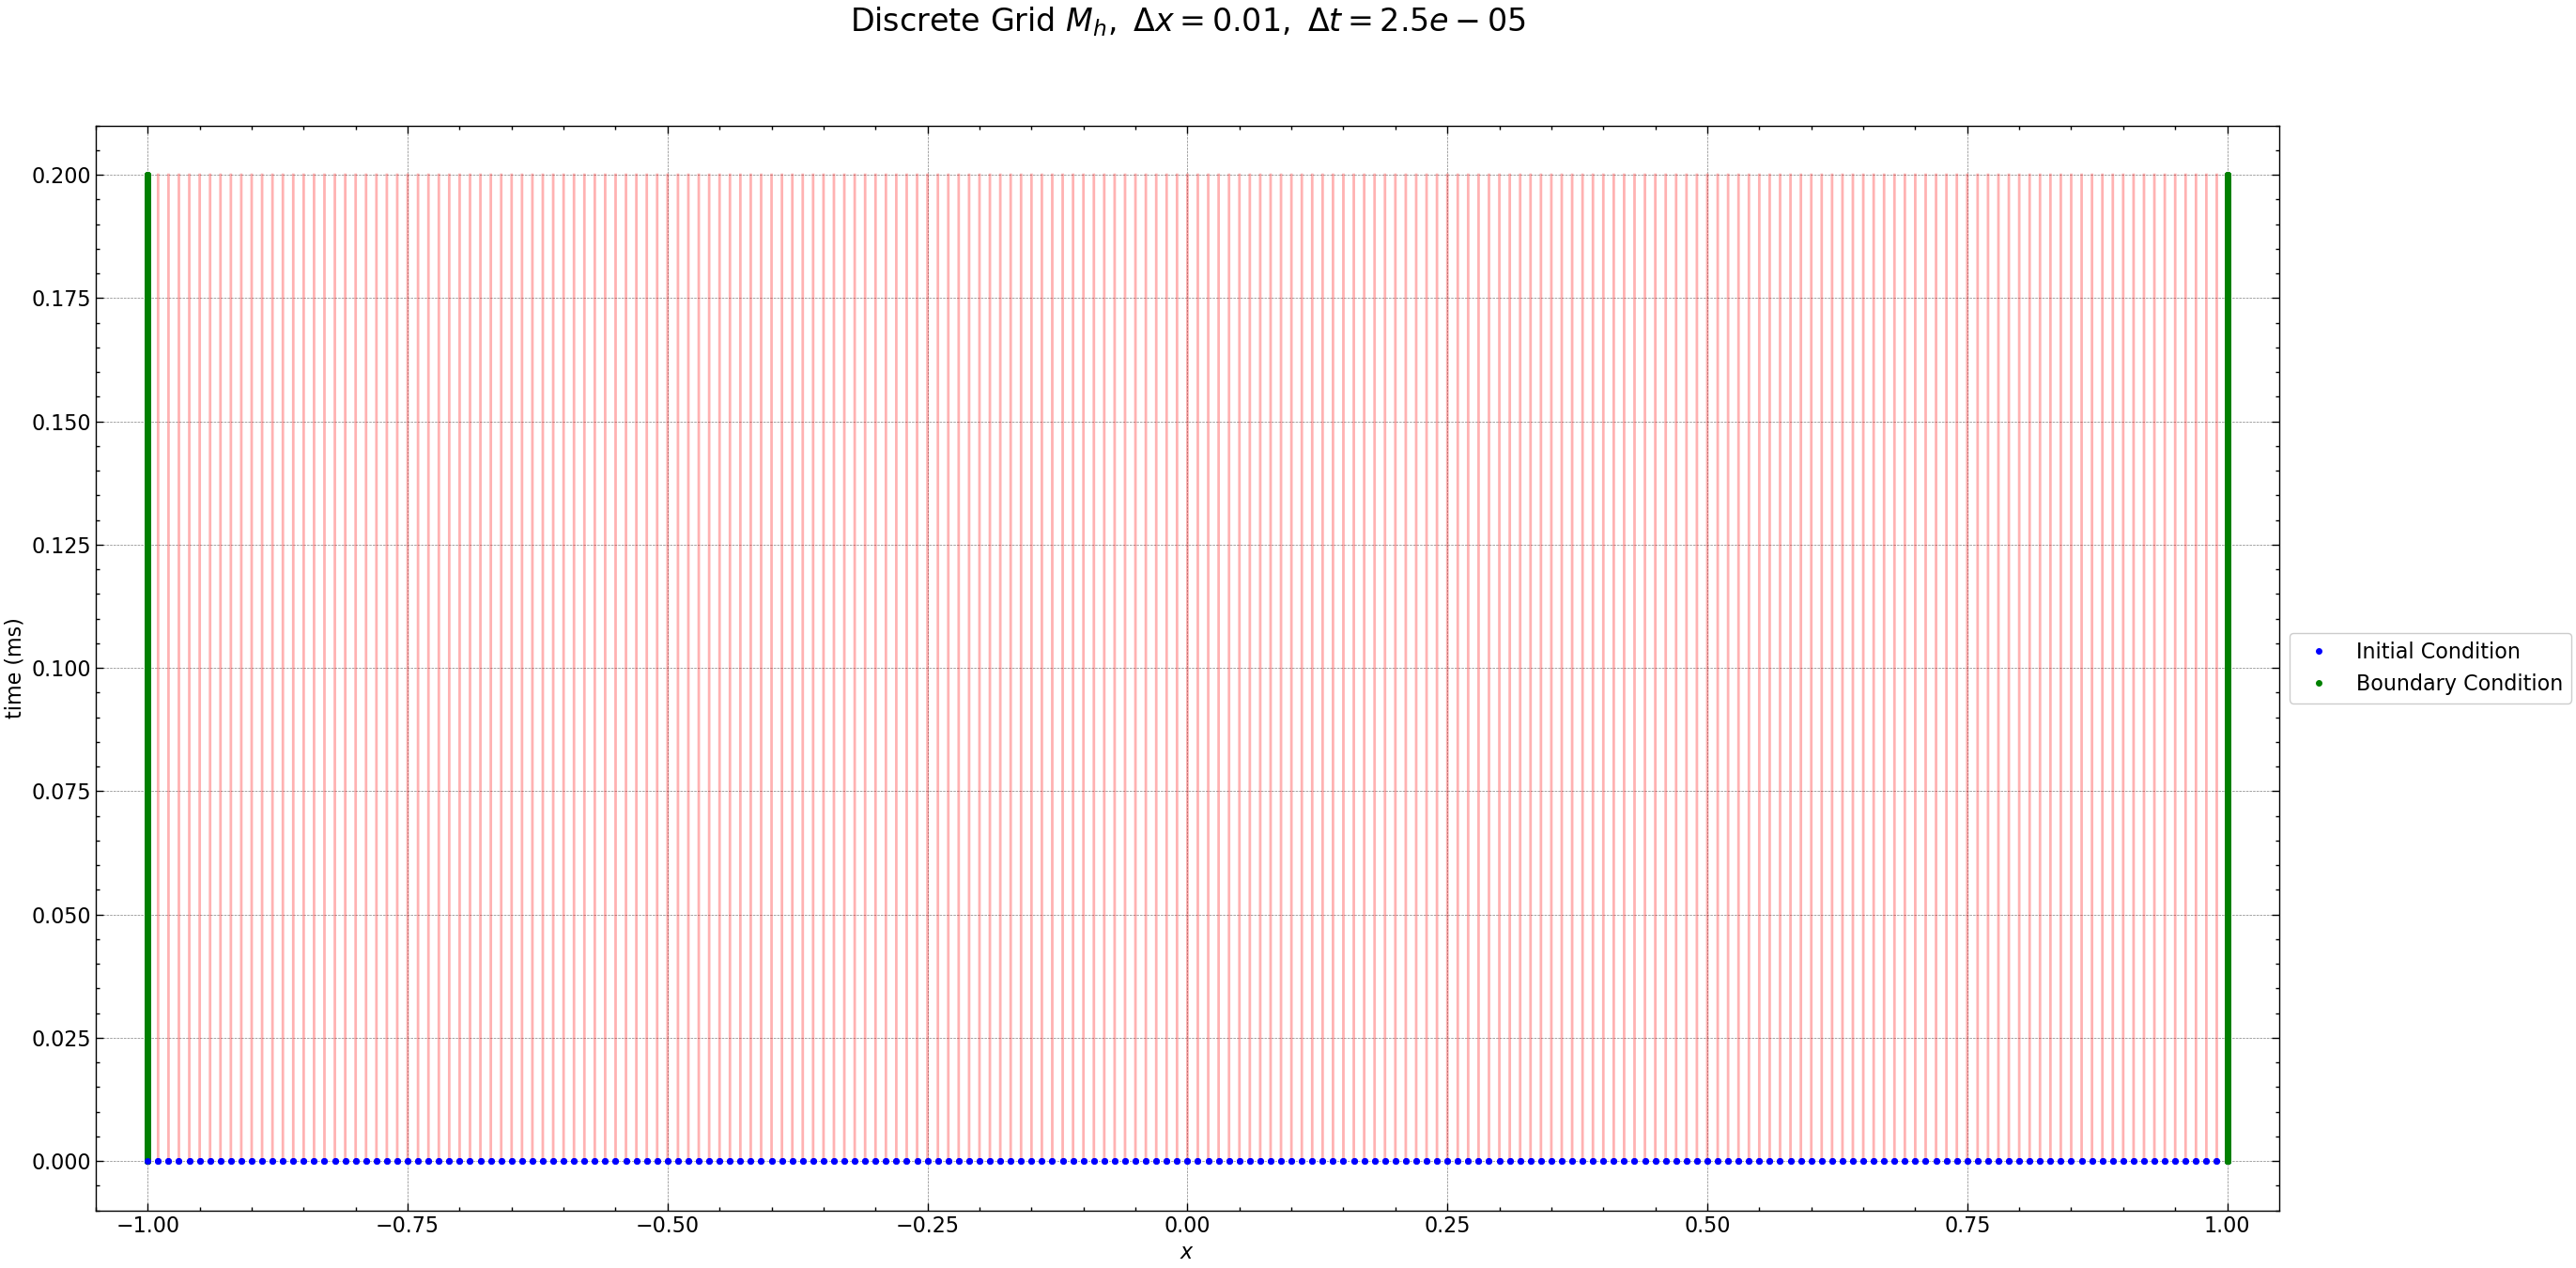

In [4]:
fig = plt.figure(figsize=(30, 15))
plt.plot(Z, Y, 'r-', alpha=0.3)  
plt.plot(z, 0 * z, 'bo', markersize=4, label='Initial Condition')  
plt.plot(np.ones(time_steps + 1) * -1, time, 'go', markersize=4, label='Boundary Condition')  
plt.plot(z, 0 * z, 'bo', markersize=4)
plt.plot(np.ones(time_steps + 1) * 1, time, 'go', markersize=4)
plt.xlim((-1.05, 1.05))  
plt.xlabel(r'$x$')
plt.ylabel(r'time (ms)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Discrete Grid $M_h,$ $\Delta x= %s,$ $\Delta t=%s$' % (h, k), fontsize=24, y=1.08)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<div align="center"><font color='blue'><h2> Analytical Solution </h2></font></div>

$$ B_r(z, t) = B_o cos(\frac{2m +1}{2} \pi z) exp( - (\frac{2m +1}{2} \pi)^2 t) $$
$$ B_\phi(z, t) = B_o cos(\frac{2n + 1}{2} \pi z) exp( - (\frac{2n +1}{2} \pi)^2 t) $$

In [5]:
def generate_random_Bo(seed_value):
    np.random.seed(seed_value)  
    random_float = np.random.rand()  
    return random_float

def initial_conditions(N, time_steps, seed_value, m, n, BCtype = "vacuum"):
    mag_br = 1000*generate_random_Bo(seed_value)
    mag_bphi = 1000*generate_random_Bo(seed_value + 1)  
    
    z = np.linspace(-1, 1, N+1)
    Br = np.zeros((N+1, time_steps+1))
    Bphi = np.zeros((N+1, time_steps+1))
    b1 = np.zeros(N-1)
    b2 = np.zeros(N-1)
    
    # Initial Condition for Br and Bphi
    for i in range(1, N+1):
        Br[i, 0] = mag_br * np.cos((m + 1/2) * np.pi * z[i])
        Bphi[i, 0] = mag_bphi * np.cos((n + 1/2)* np.pi * z[i])
    
    # Boundary Condition
    if BCtype == "vacuum":
        Br[0, :] = 0
        Bphi[0, :] = 0
        Br[N, :] = 0
        Bphi[N, :] = 0

    return z, Br, Bphi, b1, b2, mag_br, mag_bphi

In [6]:
seed_value = 50
m, n = 1, 0
z, Br, Bphi, b1, b2, mag_br, mag_bphi = initial_conditions(N, time_steps, seed_value, m, n)

## Initial Conditions

$$ B_r(z, t=0) = B_o cos(\frac{3}{2} \pi z) $$
$$ B_\phi(z, t=0) = B_o cos(\frac{1}{2} \pi z)$$

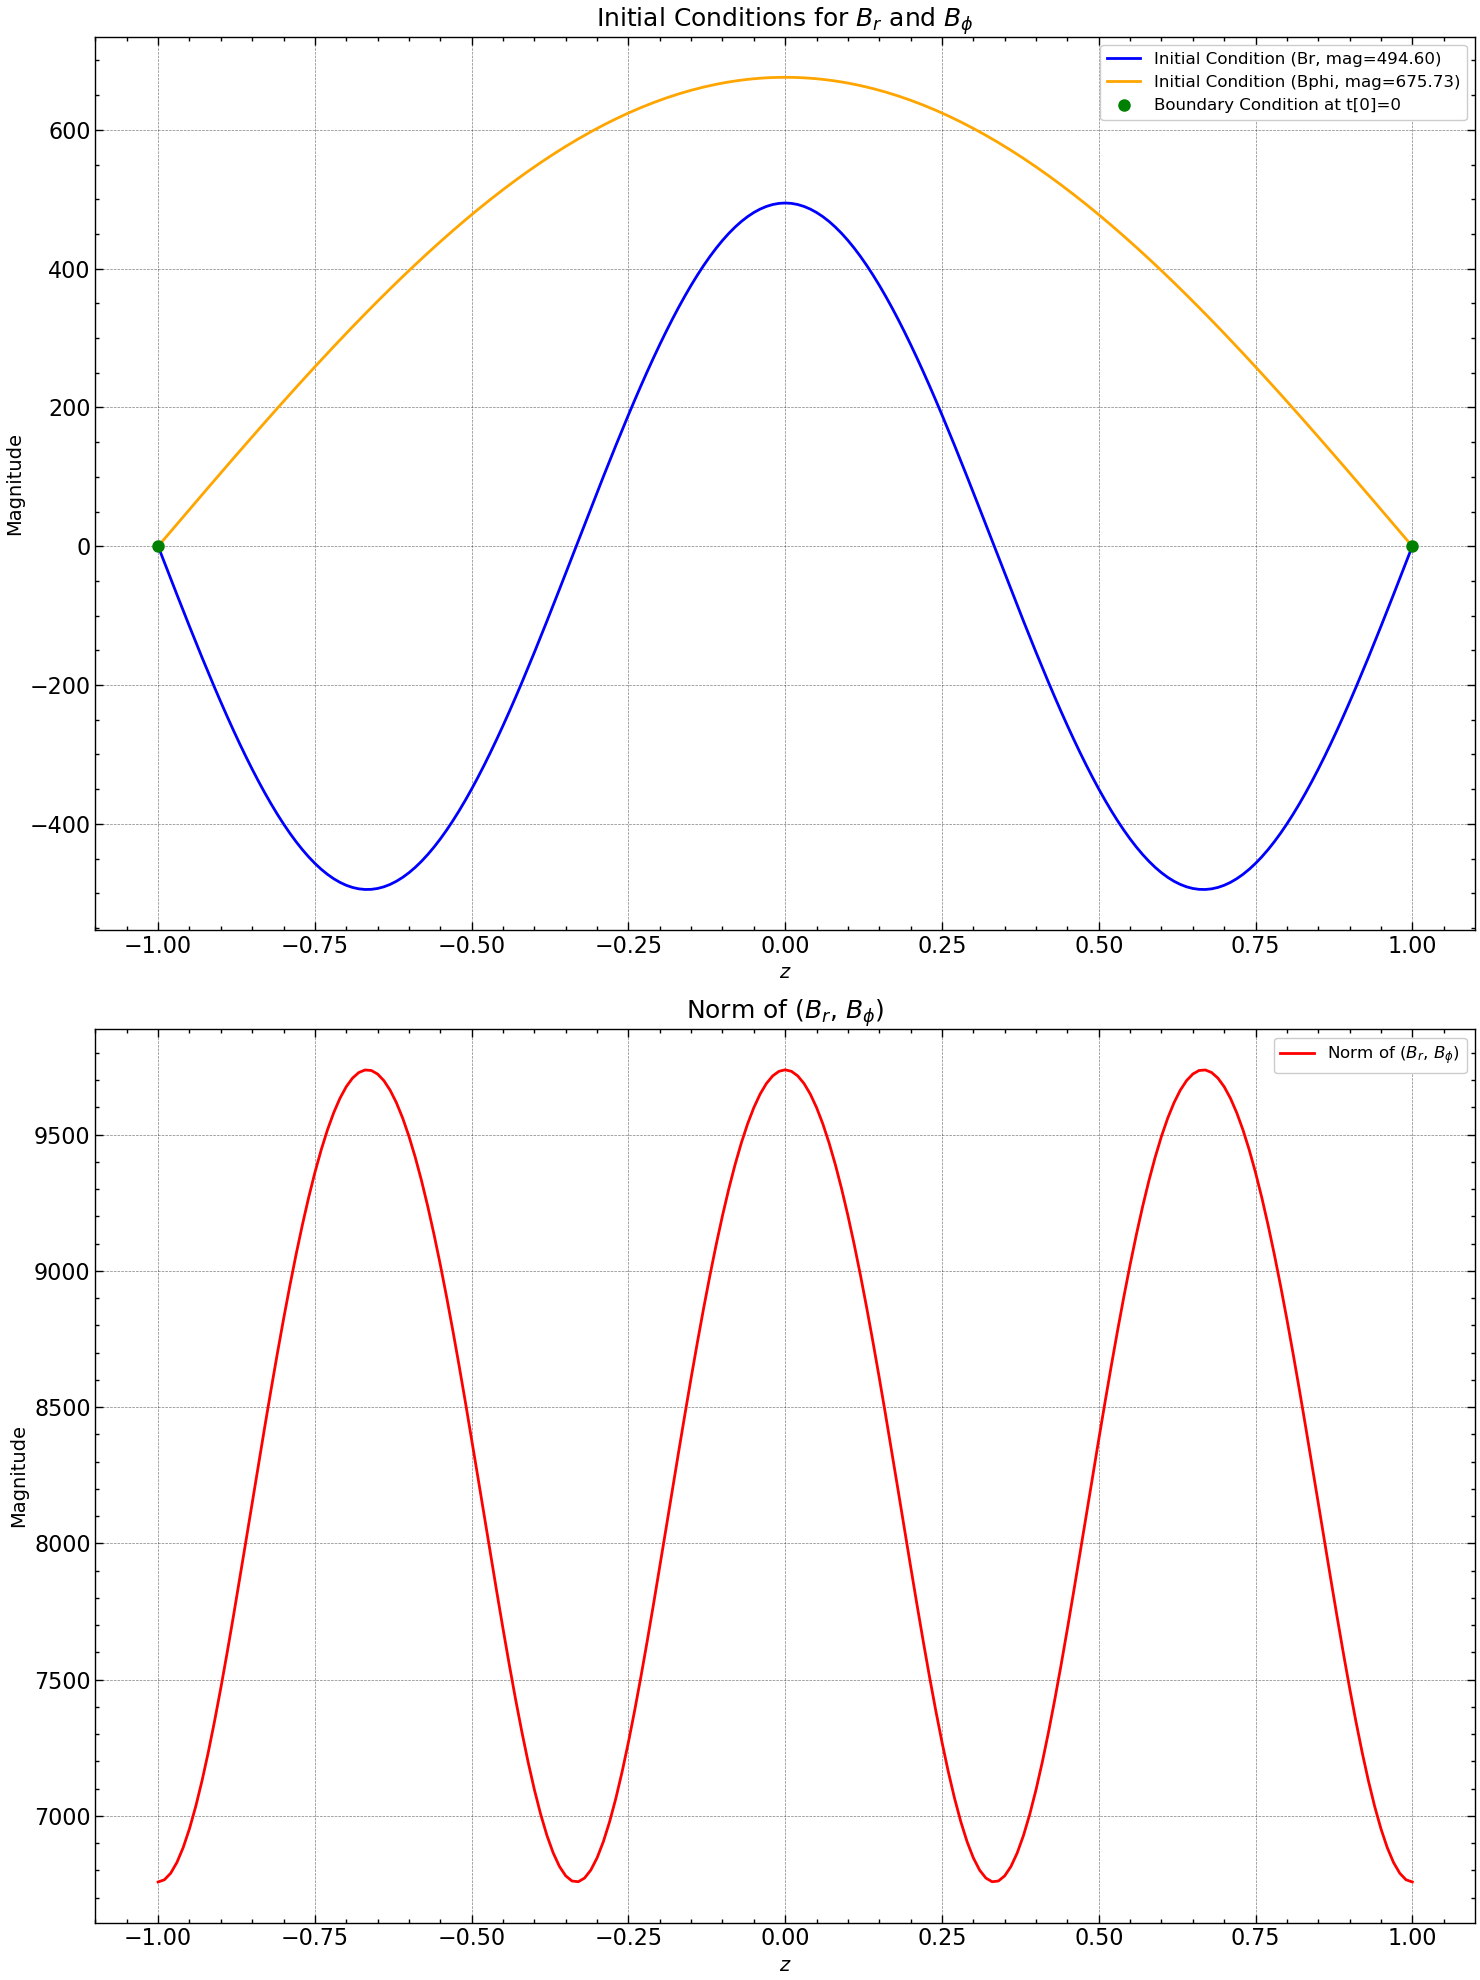

In [7]:
fig, axs = plt.subplots(2, figsize=(15, 20))

axs[0].plot(z, Br[:, 0], label=f'Initial Condition (Br, mag={mag_br:.2f})', color='blue')
axs[0].plot(z, Bphi[:,0], label=f'Initial Condition (Bphi, mag={mag_bphi:.2f})', color='orange')
axs[0].plot(z[[0, N]], Br[[0, N], 0], 'go', markersize=8, label='Boundary Condition at t[0]=0')
axs[0].set_title(r'Initial Conditions for $B_{r}$ and $B_{\phi}$', fontsize=18)
axs[0].set_xlabel(r'$z$', fontsize=14)
axs[0].set_ylabel('Magnitude', fontsize=14)
axs[0].legend(loc='upper right', fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.5)


norm_Br_Bphi = [np.linalg.norm(np.sqrt(Br[i, 0]**2 + Bphi[:,0]**2)) for i in range(len(z))]
axs[1].plot(z, norm_Br_Bphi , label=r'Norm of ($B_r$, $B_{\phi}$)', linestyle='-', color='red')
axs[1].set_title(r'Norm of ($B_{r}$, $B_{\phi}$)', fontsize=18)
axs[1].set_xlabel(r'$z$', fontsize=14)
axs[1].set_ylabel('Magnitude', fontsize=14)
axs[1].legend(loc='upper right', fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [8]:
def analytical_solution(alpha, z, t):
    """
    Calculate the analytical solution for Br and Bphi.
    
    Arguments:
    z : numpy.ndarray : Spatial grid.
    t : float : Time.
    
    Returns:
    numpy.ndarray, numpy.ndarray : Analytical solutions for Br and Bphi.
    """
    # Calculate analytical solutions for Br and Bphi
    Br_analytical = np.cos((1 + 1/2) * np.pi * z) * np.exp(-alpha * (3*np.pi/2)**2 * t)
    Bphi_analytical = np.cos((0 + 1/2) * np.pi * z) * np.exp(-alpha * (np.pi/2)**2 * t)
    
    return Br_analytical, Bphi_analytical

In [9]:
def solve_dynamo_equation(alpha, Nx, Nt, order=2):
    """
    Solve the 1D dynamo equation for Br and Bphi using finite differences with variable order.
    
    Arguments:
    alpha : float : Magnetic diffusivity.
    Nx : int : Number of spatial grid points.
    Nt : int : Number of time steps.
    order : int : Order of the finite difference scheme (default is 2).
    
    Returns:
    numpy.ndarray : Solutions for Br and Bphi over space and time.
    """
    
    start_time = timeit.time()  # Record start time
    pad_width = ((4, 4), (0, 0))  # Pad 2 elements at the beginning and end along the first axis
    Br_sol = np.pad(Br, pad_width, mode='constant', constant_values=0)
    Bphi_sol = np.pad(Bphi, pad_width, mode='constant', constant_values=0)
    
    # Iterate over time steps
    for n in range(Nt):
        if order == 2 :
            for i in range(4, Nx+4):
                    # Update Br using second-order finite differences
                    Br_sol[i, n+1] = Br_sol[i, n] + alpha * k / (h**2) * (Br_sol[i+1, n] - 2 * Br_sol[i, n] + Br_sol[i-1, n])
                    # Update Bphi using second-order finite differences
                    Bphi_sol[i, n+1] = Bphi_sol[i, n] + alpha * k / (h**2) * (Bphi_sol[i+1, n] - 2 * Bphi_sol[i, n] + Bphi_sol[i-1, n])
                    
        elif order == 4:
            for i in range(4, Nx+4):
                    # Update Br using fourth-order finite differences
                    Br_sol[i, n+1] = Br_sol[i, n] + alpha * k / (12 * h**2) * (-Br_sol[i+2, n] + 16 * Br_sol[i+1, n] - 30 * Br_sol[i, n] + 16 * Br_sol[i-1, n] - Br_sol[i-2, n])
                    # Update Bphi using fourth-order finite differences
                    Bphi_sol[i, n+1] = Bphi_sol[i, n] + alpha * k / (12 * h**2) * (-Bphi_sol[i+2, n] + 16 * Bphi_sol[i+1, n] - 30 * Bphi_sol[i, n] + 16 * Bphi_sol[i-1, n] - Bphi_sol[i-2, n])
                    
        elif order == 6:
            for i in range(4, Nx + 4):                
                # Update Br using sixth-order finite differences
                Br_sol[i, n+1] = Br_sol[i, n] + alpha * k / (180 * h**2) * (2*Br_sol[i+3, n] - 27*Br_sol[i+2, n] +270*Br_sol[i+1, n] -490*Br_sol[i, n] + 270*Br_sol[i-1, n] - 27*Br_sol[i-2, n] + 2*Br_sol[i-3, n])
                # Update Bphi using sixth-order finite differences
                Bphi_sol[i, n+1] = Bphi_sol[i, n] + alpha * k / (180 * h**2) * (2*Bphi_sol[i+3, n] - 27*Bphi_sol[i+2, n] + 270*Bphi_sol[i+1, n] -490*Bphi_sol[i,n] + 270*Bphi_sol[i-1, n] - 27*Bphi_sol[i-2, n] + 2*Bphi[i-3, n])
                
        elif order == 8:
            for i in range(4, Nx +4):
                # Update Br using eighth-order finite differences
                Br_sol[i, n+1] = Br_sol[i, n] + alpha * k / (h**2) * (-1/560*Br_sol[i+4, n] +8/315*Br_sol[i+3, n] -1/5*Br_sol[i+2, n] +8/5*Br_sol[i+1, n] -205/72*Br_sol[i, n] +8/5*Br_sol[i-1, n] -1/5*Br_sol[i-2, n] +8/315*Br_sol[i-3, n] -1/560*Br_sol[i-4, n])
                # Update Bphi using eighth-order finite differences
                Bphi_sol[i, n+1] = Bphi_sol[i, n] + alpha * k / (h**2) * (-1/560*Bphi_sol[i+4, n] + 8/315*Bphi_sol[i+3, n] -1/5*Bphi_sol[i+2, n] + 8/5*Bphi_sol[i+1, n] -205/72*Bphi_sol[i, n] +8/5*Bphi_sol[i-1, n] -1/5*Bphi_sol[i-2, n] + 8/315*Bphi_sol[i-3, n] -1/560*Bphi_sol[i-4, n])
                
    end_time = timeit.time()  
    elapsed_time = end_time - start_time 
    
    Br_sol = Br_sol[4:-4, :]
    Bphi_sol = Bphi_sol[4:-4, :]
        
    return Br_sol, Bphi_sol, elapsed_time 


**Test 1**: Evaluation of Solution Accuracy and Computational Cost with Higher Order Discretization Schemes

This test aims to assess how the solution accuracy and computational cost vary when employing higher-order discretization schemes for second-order derivatives. The comparison will maintain identical mesh parameters throughout the analysis.

In [10]:
orders = [2, 4, 8]

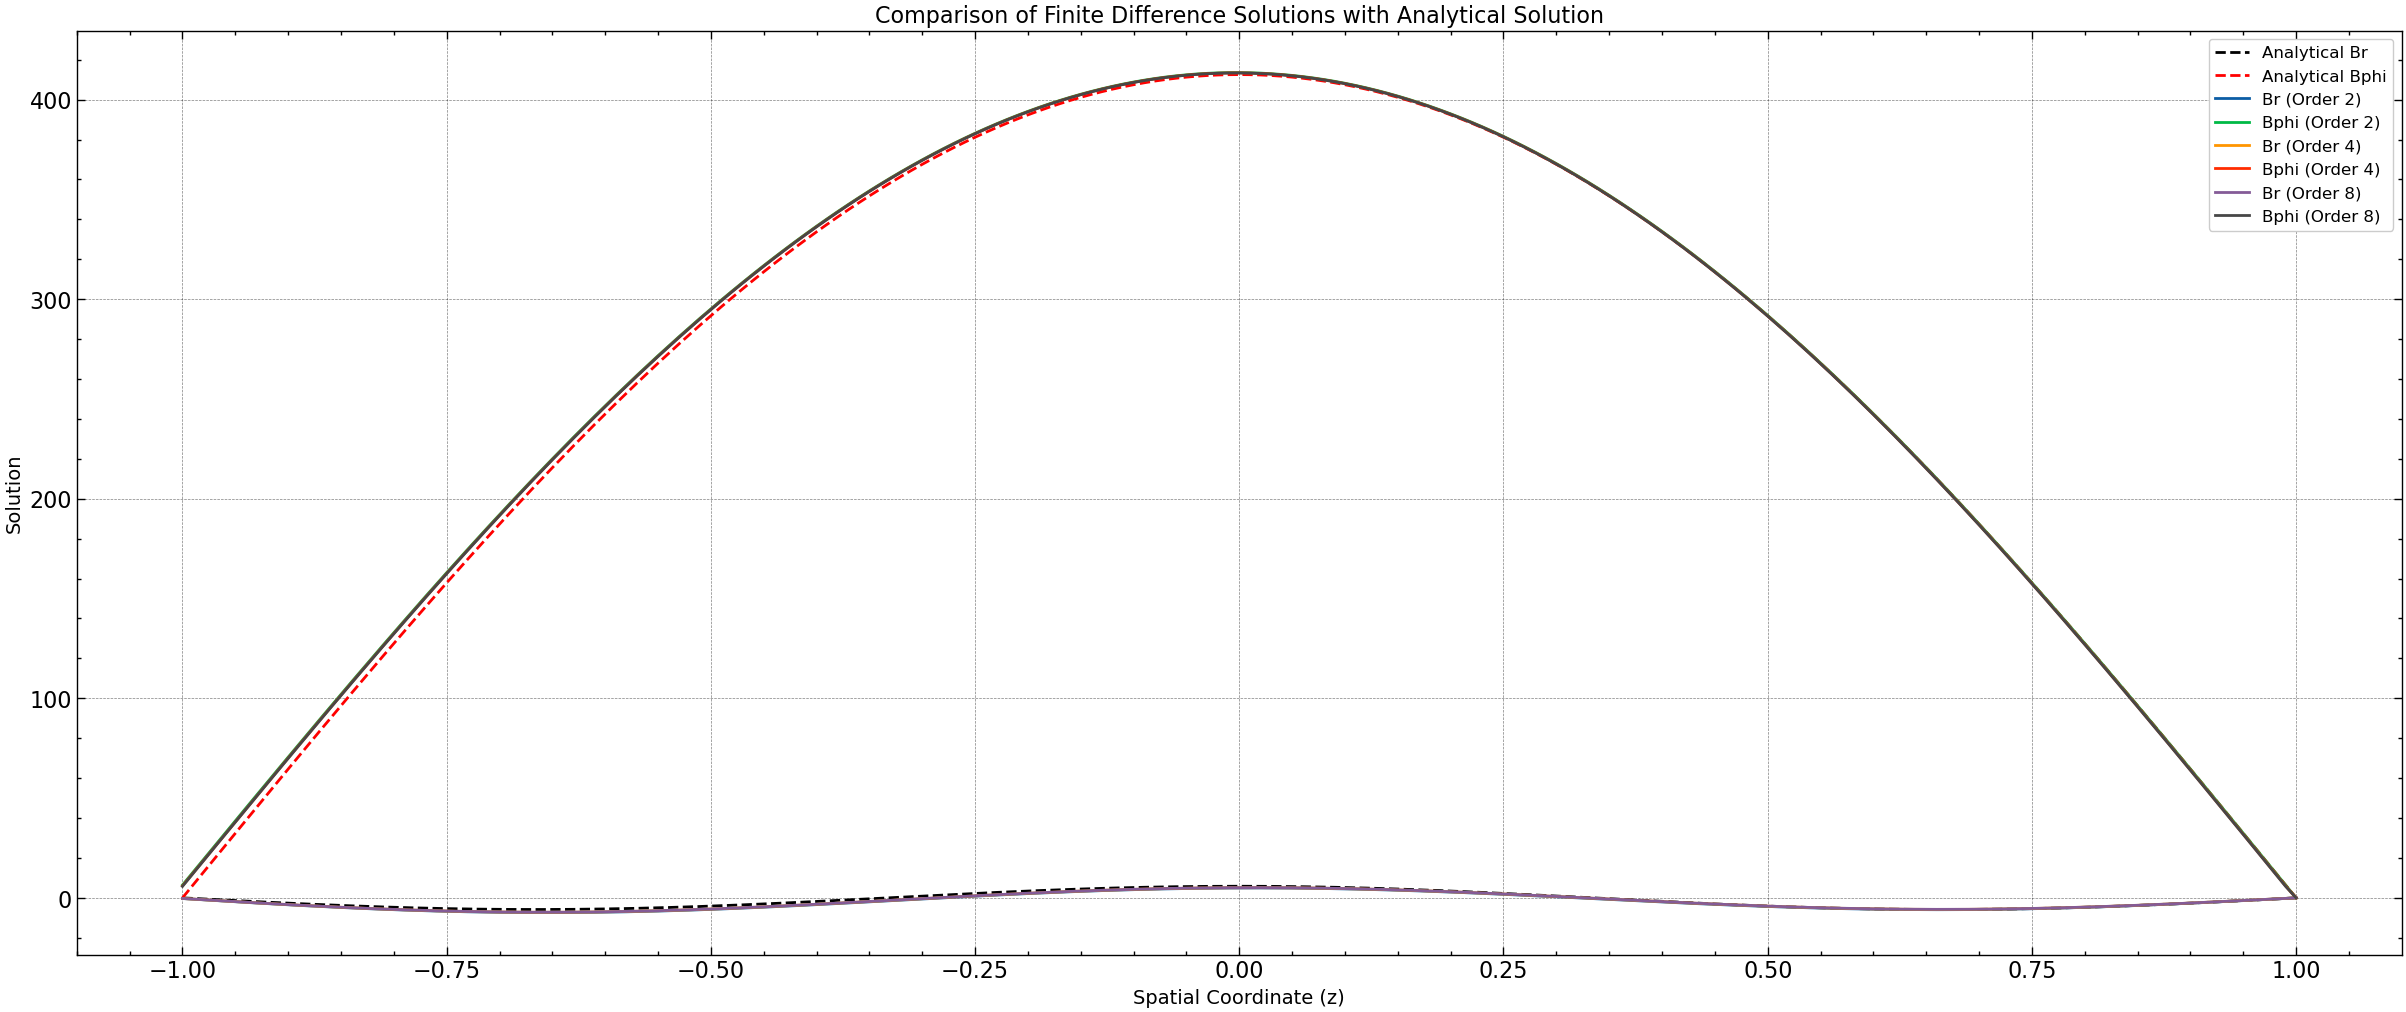

In [11]:
plt.figure(figsize=(30, 12))
plt.title("Comparison of Finite Difference Solutions with Analytical Solution", fontsize=16)
plt.xlabel("Spatial Coordinate (z)", fontsize=14)
plt.ylabel("Solution", fontsize=14)
plt.grid(True)

time_results = []
l2_norm_results = []

t = time[-1]  
Br_analytical, Bphi_analytical = analytical_solution(eta_t, z, t)
plt.plot(z, mag_br*Br_analytical, label="Analytical Br", linestyle='--', color='black', linewidth=2)
plt.plot(z, mag_bphi*Bphi_analytical, label="Analytical Bphi", linestyle='--', color='red', linewidth=2)

# Iterate over orders
for order in orders:
    # dynamo equation for the current order
    Br_solution, Bphi_solution, elapsed_time = solve_dynamo_equation(eta_t, N, time_steps, order)
    
    l2_norm_br = np.linalg.norm(np.abs(Br_solution[:, -1] - mag_br*Br_analytical))
    l2_norm_bphi = np.linalg.norm(np.abs(Bphi_solution[:, -1] - mag_bphi*Bphi_analytical))
    
    time_results.append([order, elapsed_time])
    l2_norm_results.append([order, l2_norm_br, l2_norm_bphi])
    
    # Plot the solution for Br
    plt.plot(z, Br_solution[:, -1], label=f"Br (Order {order})", linestyle='-', linewidth=2)

    # Plot the solution for Bphi
    plt.plot(z, Bphi_solution[:, -1], label=f"Bphi (Order {order})", linestyle='-', linewidth=2)

plt.legend(fontsize=12)
plt.show()

Mesh Parameters $M_h$
- $\Delta x= 0.01$
- $\Delta t=2.5e-05$
- $\alpha = 0.125$

In [19]:
combined_results = []
for time_result, l2_norm_result in zip(time_results, l2_norm_results):
    combined_results.append(time_result + l2_norm_result[1:])

# Print tables side by side
print("Simulation Times and L2 Norms:")
print(tabulate(combined_results, headers=["Order", "Time (s)", "L2 Norm Br", "L2 Norm Bphi"], tablefmt="pretty"))


Mesh Parameters $M_h$, $\Delta x= 0.01$, $\Delta t=2.5e-05$, $\alpha = 0.125$
Simulation Times and L2 Norms:
+-------+--------------------+--------------------+-------------------+
| Order |      Time (s)      |     L2 Norm Br     |   L2 Norm Bphi    |
+-------+--------------------+--------------------+-------------------+
|   2   | 2.0895631313323975 | 13.733984971830152 | 39.80352747733797 |
|   4   | 2.8466551303863525 | 12.301714047444344 | 36.65689737842187 |
|   8   | 4.521578073501587  | 11.866796403667742 | 35.70839970827103 |
+-------+--------------------+--------------------+-------------------+


The results of the simulations reveal that as the order of the finite difference scheme increases, the computational time also increases. However, higher-order schemes tend to produce solutions with lower L2 norms, indicating better accuracy compared to lower-order schemes. This improvement in accuracy comes at the cost of increased computational time. In this particular case, the fourth-order scheme exhibits slightly lower L2 norms compared to the second-order scheme, suggesting better accuracy. However, the computational time for the fourth-order scheme is slightly higher. On the other hand, the eighth-order scheme further improves the accuracy but requires significantly more computational time compared to lower-order schemes.

**Test 2**: Simulation Results with Varying Magnetic Diffusivity $\eta_T$

Physically, the magnetic diffusivity parameter governs the rate at which magnetic fields diffuse through a medium, influencing the evolution of magnetic fields in dynamo equations. In the analysis above, we observed that it explicitly serves as one of the parameters regulating the CFL condition, ensuring the stability of the solution.

In [33]:
eta_values = [0.5, 1, 1.5, 2, 2.5]


Simulation Times for eta_t = 0.5:
  Order    Time (s)
-------  ----------
      2     2.03795
      4     2.77515
      8     4.4053

L2 Norms for eta_t = 0.5:
  Order    L2 Norm Br    L2 Norm Bphi
-------  ------------  --------------
      2       26.1254         39.8843
      4       24.0766         36.9819
      8       23.492          36.0994

Simulation Times for eta_t = 1:
  Order    Time (s)
-------  ----------
      2     1.82199
      4     2.83364
      8     4.44742

L2 Norms for eta_t = 1:
  Order    L2 Norm Br    L2 Norm Bphi
-------  ------------  --------------
      2       13.734          39.8035
      4       12.3017         36.6569
      8       11.8668         35.7084

Simulation Times for eta_t = 1.5:
  Order    Time (s)
-------  ----------
      2     1.76688
      4     2.80644
      8     4.54483

L2 Norms for eta_t = 1.5:
  Order    L2 Norm Br    L2 Norm Bphi
-------  ------------  --------------
      2       9.33019         37.1146
      4       8.05084    

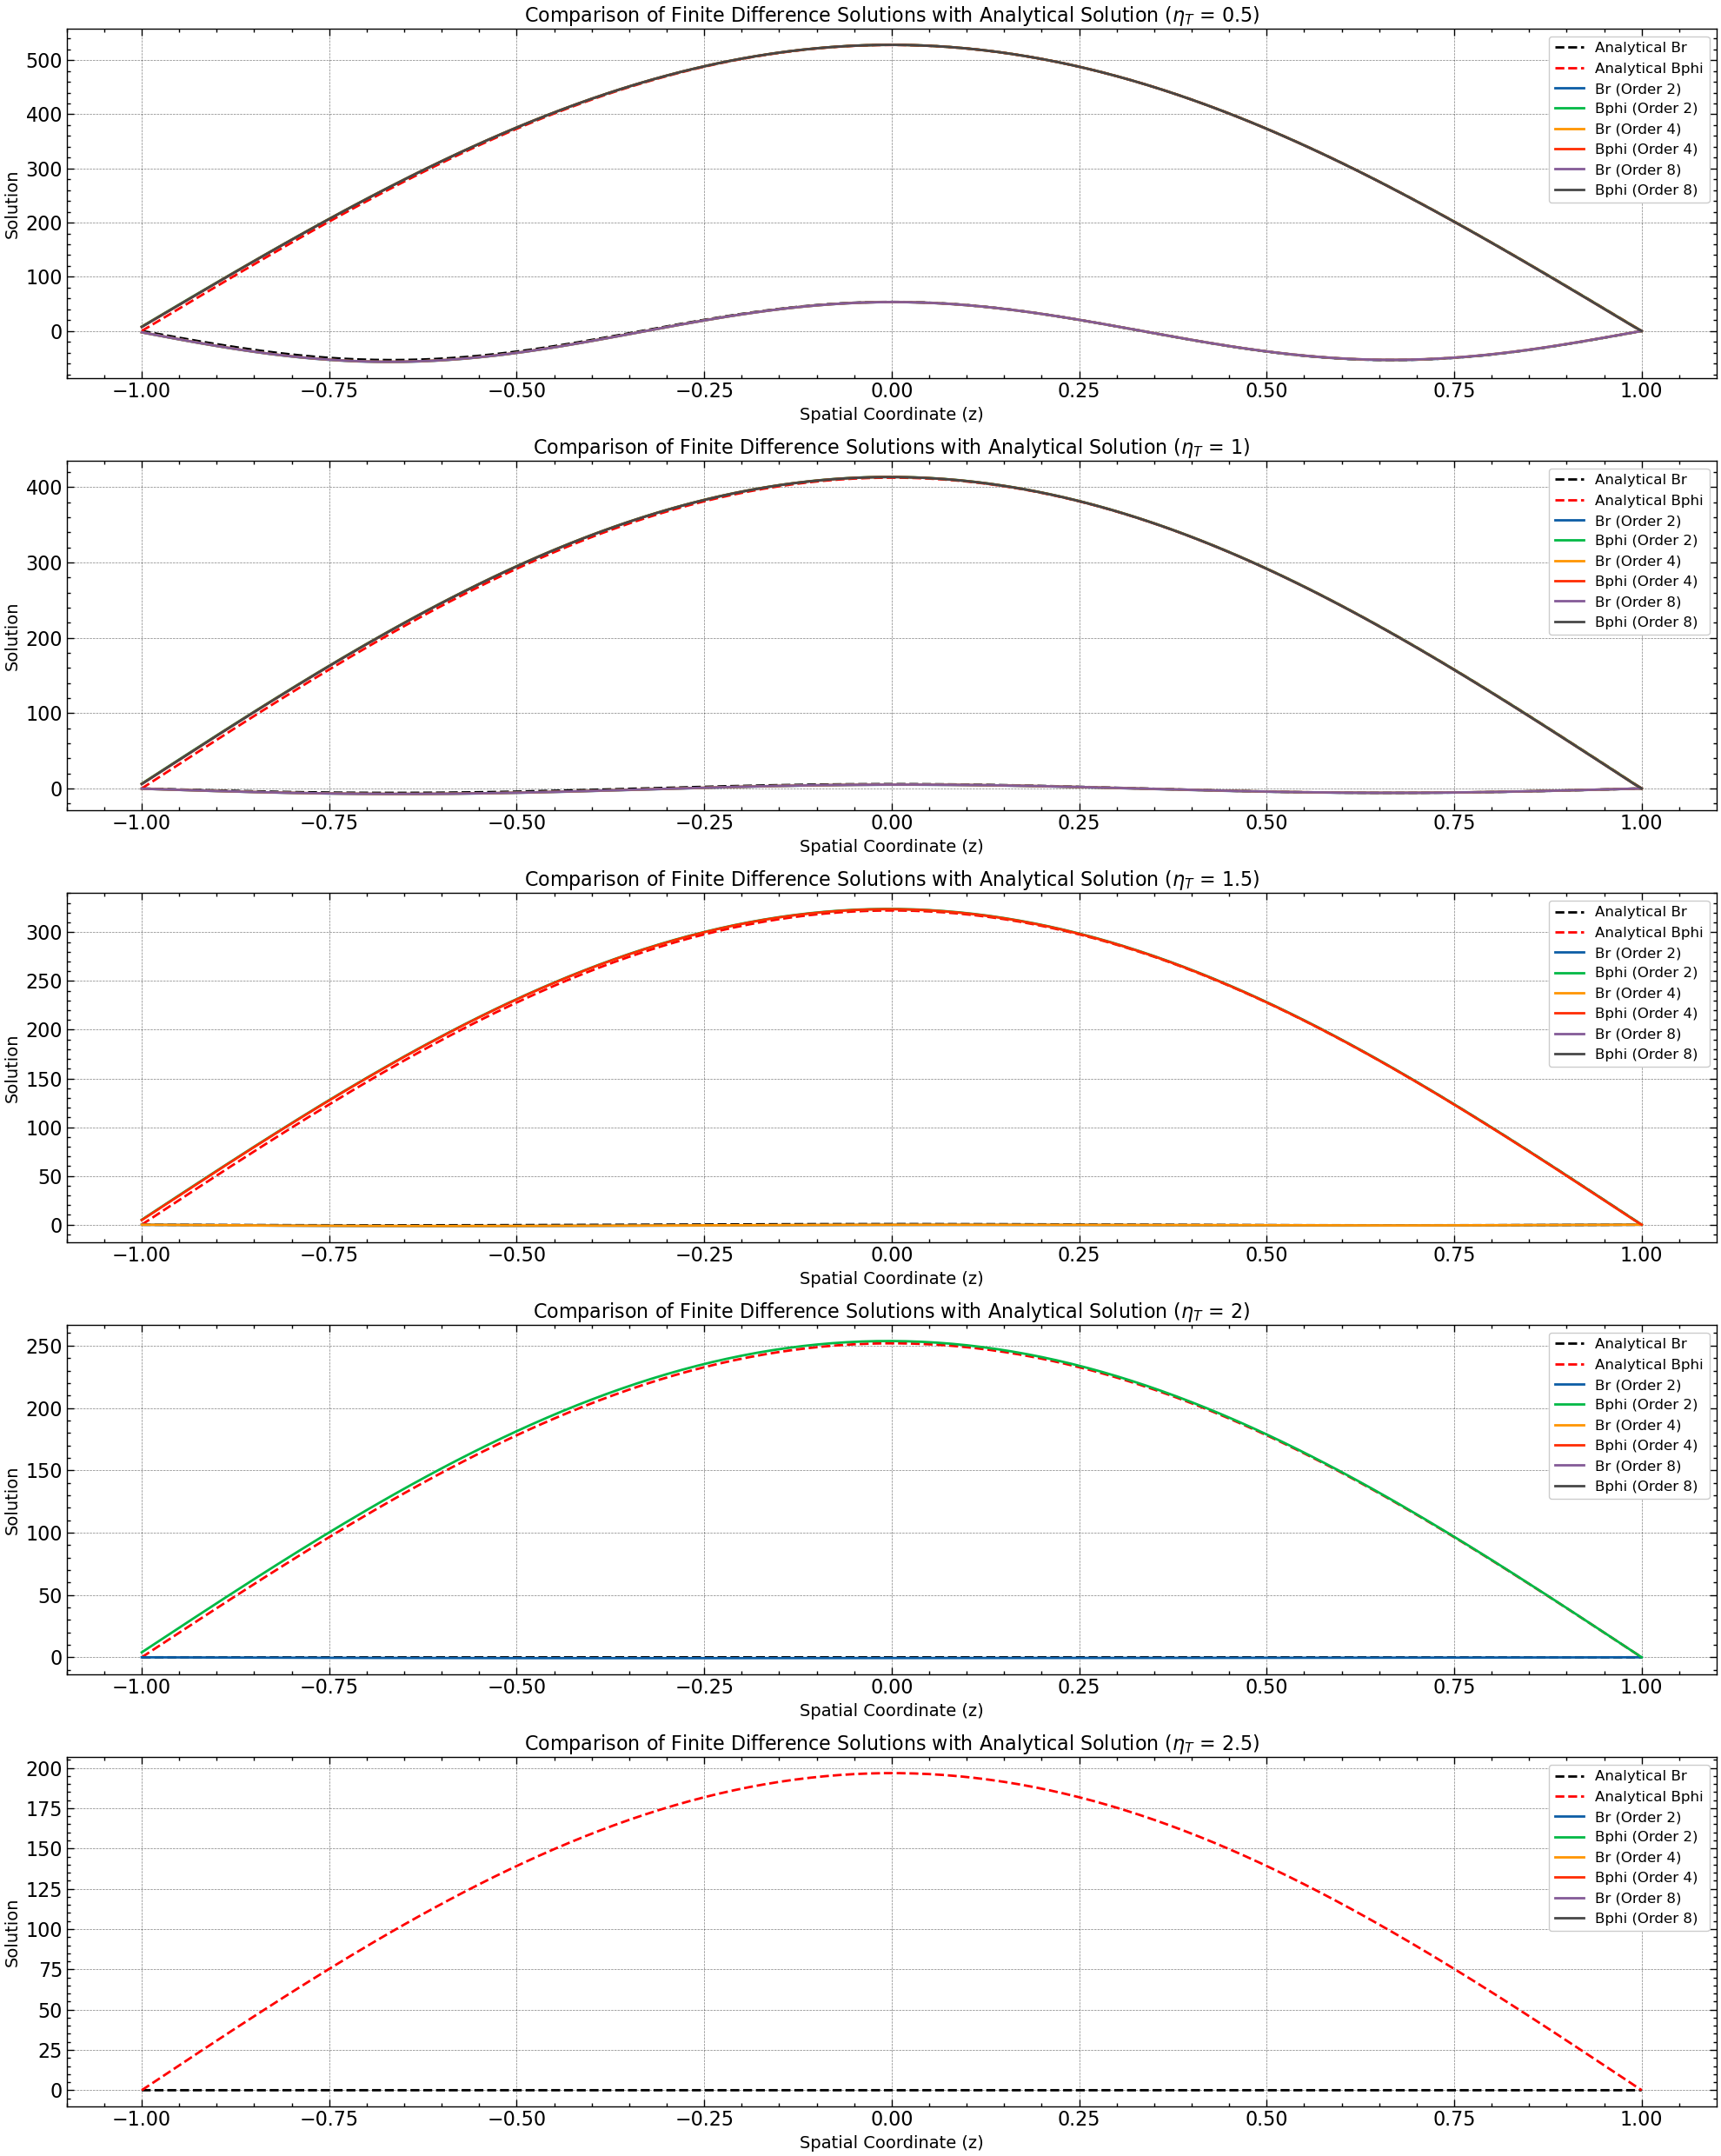

In [36]:
fig, axs = plt.subplots(5, figsize=(20, 25))

all_time_results = []
all_l2_norm_results = []

for idx, eta_t in enumerate(eta_values):
    axs[idx].set_title(r"Comparison of Finite Difference Solutions with Analytical Solution ($\eta_T$ = %s)" %eta_t, fontsize=16)
    axs[idx].set_xlabel("Spatial Coordinate (z)", fontsize=14)
    axs[idx].set_ylabel("Solution", fontsize=14)
    axs[idx].grid(True)

    time_results = []
    l2_norm_results = []

    t = time[-1]  
    Br_analytical, Bphi_analytical = analytical_solution(eta_t, z, t)
    axs[idx].plot(z, mag_br*Br_analytical, label="Analytical Br", linestyle='--', color='black', linewidth=2)
    axs[idx].plot(z, mag_bphi*Bphi_analytical, label="Analytical Bphi", linestyle='--', color='red', linewidth=2)

    # Iterate over orders
    for order in orders:
        # Solve dynamo equation for the current order
        Br_solution, Bphi_solution, elapsed_time = solve_dynamo_equation(eta_t, N, time_steps, order)
        
        # Calculate L2 norms
        l2_norm_br = np.linalg.norm(np.abs(Br_solution[:, -1] - mag_br*Br_analytical))
        l2_norm_bphi = np.linalg.norm(np.abs(Bphi_solution[:, -1] - mag_bphi*Bphi_analytical))
        
        # Append results to lists
        time_results.append([order, elapsed_time])
        l2_norm_results.append([order, l2_norm_br, l2_norm_bphi])
        
        # Plot the solution for Br
        axs[idx].plot(z, Br_solution[:, -1], label=f"Br (Order {order})", linestyle='-', linewidth=2)

        # Plot the solution for Bphi
        axs[idx].plot(z, Bphi_solution[:, -1], label=f"Bphi (Order {order})", linestyle='-', linewidth=2)
        

    axs[idx].legend(fontsize=12)

    print(f"\nSimulation Times for eta_t = {eta_t}:")
    print(tabulate(time_results, headers=["Order", "Time (s)"]))

    print(f"\nL2 Norms for eta_t = {eta_t}:")
    print(tabulate(l2_norm_results, headers=["Order", "L2 Norm Br", "L2 Norm Bphi"]))

plt.tight_layout()
plt.show()

## Results

**Simulation Results for Different Values of $\eta_t$**

| eta_t | Order | Time (s) | L2 Norm Br | L2 Norm Bphi |
|-------|-------|----------|------------|--------------|
| 0.5   |   2   |  2.03795 |   26.1254  |    39.8843   |
| 0.5   |   4   |  2.77515 |   24.0766  |    36.9819   |
| 0.5   |   8   |  4.4053  |   23.492   |    36.0994   |
| 1     |   2   |  1.82199 |   13.734   |    39.8035   |
| 1     |   4   |  2.83364 |   12.3017  |    36.6569   |
| 1     |   8   |  4.44742 |   11.8668  |    35.7084   |
| 1.5   |   2   |  1.76688 |   9.33019  |    37.1146   |
| 1.5   |   4   |  2.80644 |   8.05084  |    33.7434   |
| 1.5   |   8   |          |            |              |
| 2     |   2   |  1.83046 |   7.01351  |    33.7372   |
| 2     |   4   |  2.86099 |            |              |
| 2     |   8   |  4.60799 |            |              |
| 2.5   |   2   |  1.77133 |            |              |
| 2.5   |   4   |  2.81081 |            |              |
| 2.5   |   8   |  4.55267 |            |              |


## Discussion & Conclusion

In our study of the dynamo equation, we explored the influence of the magnetic diffusivity parameter, denoted by $\eta_t$, on the stability and accuracy of numerical simulations. Specifically, we focused on how $\eta_t$ controls the CFL condition, which determines the maximum allowable time step in numerical simulations to maintain stability.Our analysis revealed that the CFL condition is directly affected by the ratio of the time step $\Delta t$ to the square of the spatial discretization $\Delta x$ and the magnetic diffusivity parameter $\eta_t$. This relationship ensures that changes in the solution over time do not propagate too quickly relative to the spatial discretization. As we increased the order of the finite difference schemes used in our simulations, we observed improvements in solution accuracy, as evidenced by lower L2 norms for both Br and Bphi. However, we also encountered a trade-off: while higher-order schemes yield better accuracy, they become increasingly unstable with larger values of $\eta_t$. Interestingly, our results demonstrated that for certain values of $\eta_t$, lower-order schemes could perform comparably well to higher-order schemes in terms of our chosen metrics. This suggests that there is a critical balance between the accuracy gained from higher-order schemes and the stability required to prevent solution blow-up. Furthermore, as $\eta_t$ increased beyond a certain threshold, even lower-order schemes struggled to maintain stability, leading to divergent solutions. This underscores the importance of carefully selecting both the numerical scheme and the value of $\eta_t$ to ensure reliable and accurate simulations.

By this work we aim to highlight the intricate interplay between the magnetic diffusivity parameter $\eta_t$, the order of finite difference schemes, and the stability of numerical solutions in dynamo equations. By understanding and appropriately controlling these factors, one can model and analyze magnetic field dynamics in various physical systems, from astrophysical phenomena to laboratory experiments. However, caution must be exercised to avoid instability issues associated with high values of $\eta_t$ and excessively high-order schemes, emphasizing the need for careful consideration and validation in numerical simulations of dynamo processes.